In [1]:
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence


# always have same random state across all code files
with open('random_state.txt')as f:
    random_state= int(f.readline())
    
print(random_state)

13


In [2]:
import sklearn 
sklearn.__version__

'1.2.0'

In [3]:
xgboost.__version__

'1.7.1'

## Load and prepare data same way as when training model

In [4]:
# load prepared dataset (encoded categorical data, no missing values)
diss = pd.read_csv("data/in_situ_data_for_regression.csv")
diss.columns

# determine weights
studysize = {}
for s in diss["Source_abbrev"].unique():   
    studysize[s] = diss[diss["Source_abbrev"] == s]["Omega_calc23"].count()

#sample weight
weights = [max(studysize.values())/studysize[s] for s in diss["Source_abbrev"]]


# split data in test and training
feature_names = ["Omega_use", "Size_num", "Deployment_d", 'Material_num',
          "Device_num", "inorg_treated", "Mesh", 'Method_num']

X = diss[feature_names]
y = diss["Rate_mass"]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, 
                                                                     weights, 
                                                                     train_size=0.8, 
                                                                     random_state=random_state,
                                                                     shuffle=True)
print(X_train.shape)
print(X_test.shape)

(463, 8)
(116, 8)


## Load model

In [5]:
xgbr = xgboost.XGBRegressor()
xgbr.load_model("data/xgboost_regressor_dissolution_rate.json")


# test if model gives same results 
y_pred = xgbr.predict(X_test)
print("R2 score          ", round(r2_score(y_test, y_pred, sample_weight=w_test),3))
print("RMSE              ", round(mean_squared_error(y_test, y_pred, squared=False, sample_weight=w_test),3))
print("Mean abs. err.    ", round(mean_absolute_error(y_test, y_pred, sample_weight=w_test),3))

R2 score           0.824
RMSE               0.079
Mean abs. err.     0.049


### Figure 7

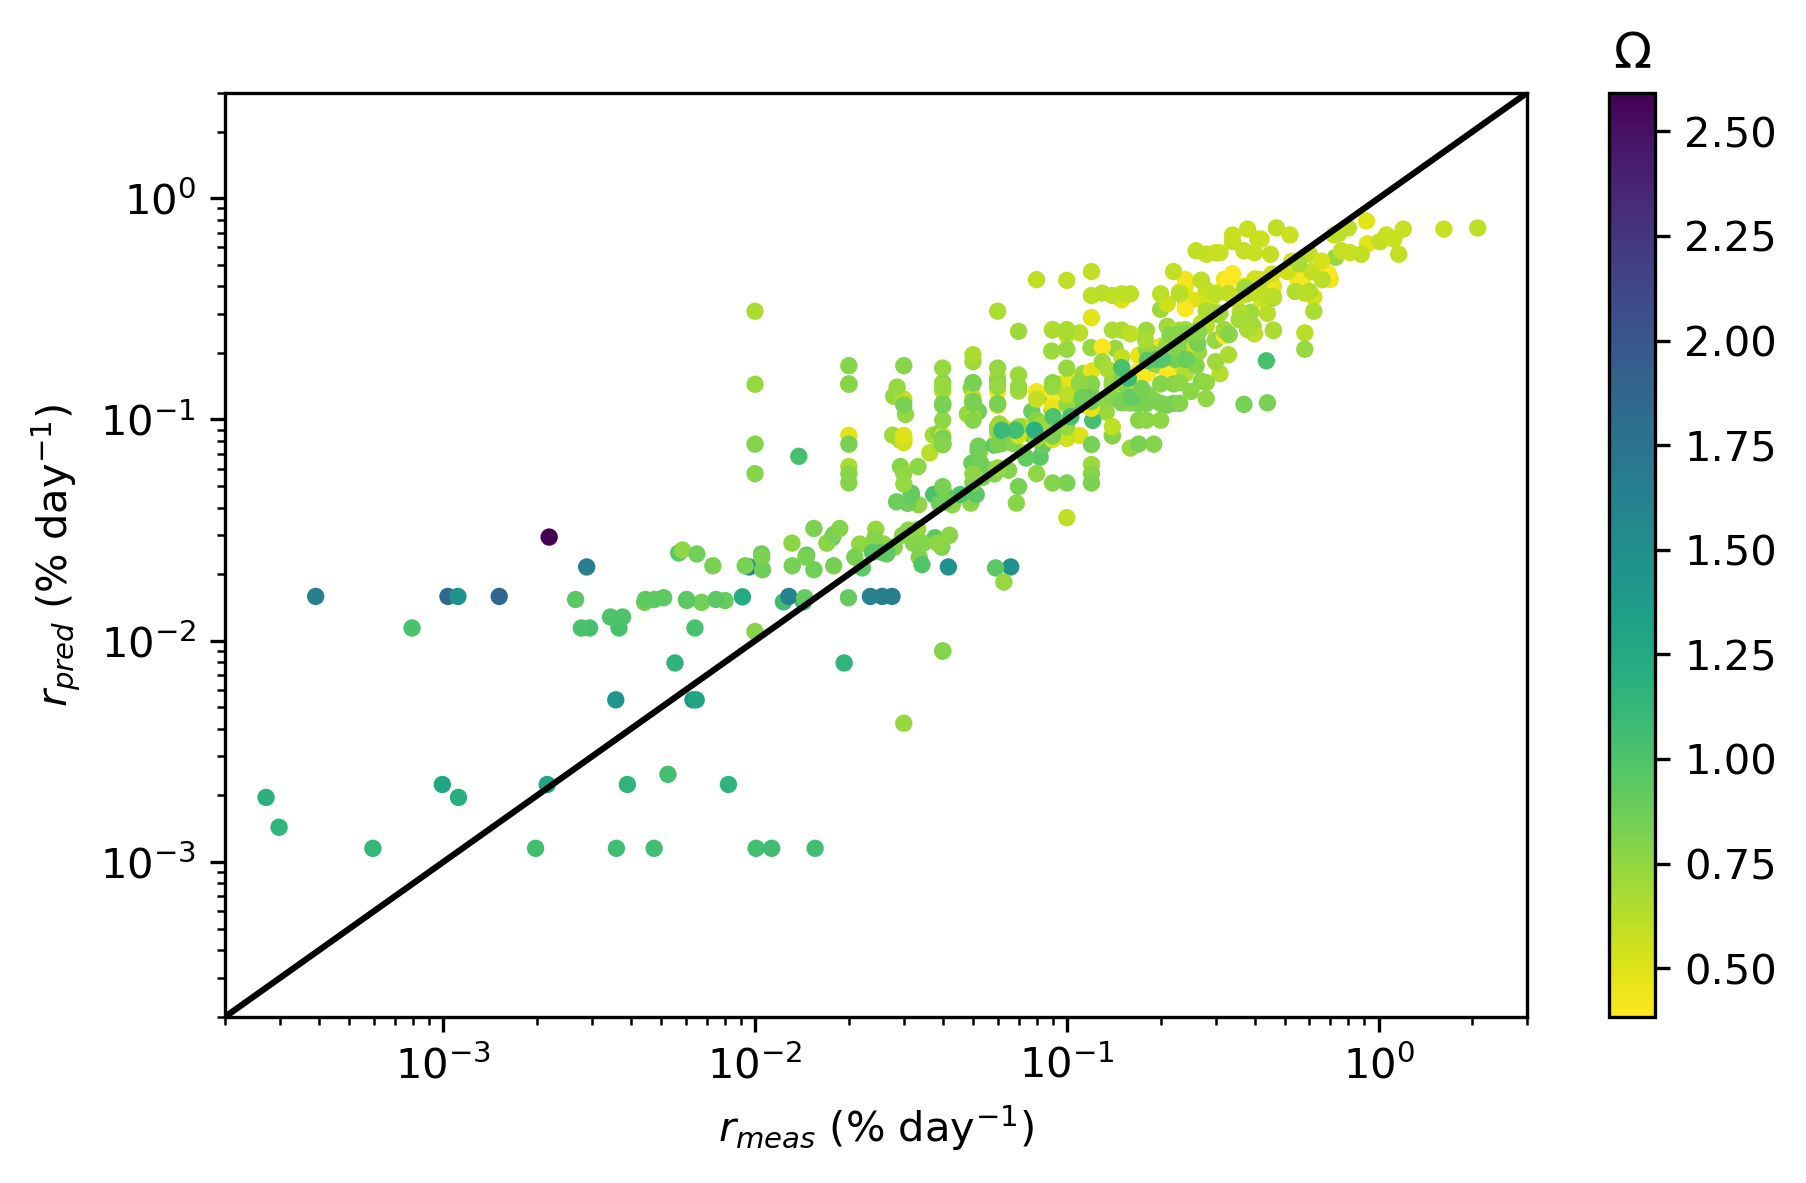

In [6]:
y_all = xgbr.predict(X)

fig, ax = plt.subplots(figsize=(7,4), dpi=300)
plt.scatter(y, y_all, c=diss['Omega_use'], s=10, cmap='viridis_r')
#plt.colorbar(label='$\Omega$')
clb = plt.colorbar()
clb.ax.set_title('$\Omega$')


ax.set_xlabel('$r_{meas}$ (% day$^{-1}$)')
ax.set_ylabel('$r_{pred}$ (% day$^{-1}$)')
ax.axline((0.1, 0.1), slope=1, color='black', label='by slope')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-4,3)
plt.ylim(2e-4,3)

plt.show()

## Permutation Feature Importance

In [7]:

for rs in range(20):

    scoring = ['r2', 'neg_mean_squared_error']
    r_multi = permutation_importance(
        xgbr, X_test, y_test, n_repeats=30, sample_weight = w_test, random_state=rs, scoring=scoring)
    
    r = r_multi['neg_mean_squared_error']

    # calculate percentages (not sure if that is "allowed")
    pfi_pct = {}
    for i, f in enumerate(feature_names):
        pfi_pct[f] = round(r.importances_mean[i]/r.importances_mean.sum() * 100, 1) 

    #print(pfi_pct)
    #print()

In [8]:
scoring = ['r2', 'neg_mean_squared_error']
r_multi = permutation_importance(
    xgbr, X_test, y_test, n_repeats=30, sample_weight = w_test, random_state=random_state, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]: 
        print(f"    {feature_names[i]}"
              f"              {r.importances_mean[i]:.5f}"
              f"  +/- {r.importances_std[i]:.5f}")

r2
    Omega_use              1.77793  +/- 0.41852
    inorg_treated              0.16490  +/- 0.03199
    Deployment_d              0.11005  +/- 0.02196
    Device_num              0.09336  +/- 0.03602
    Size_num              0.08642  +/- 0.02292
    Mesh              0.08238  +/- 0.02828
    Material_num              0.05888  +/- 0.01635
    Method_num              0.00219  +/- 0.00037
neg_mean_squared_error
    Omega_use              0.06335  +/- 0.01491
    inorg_treated              0.00588  +/- 0.00114
    Deployment_d              0.00392  +/- 0.00078
    Device_num              0.00333  +/- 0.00128
    Size_num              0.00308  +/- 0.00082
    Mesh              0.00294  +/- 0.00101
    Material_num              0.00210  +/- 0.00058
    Method_num              0.00008  +/- 0.00001


### Figure S14

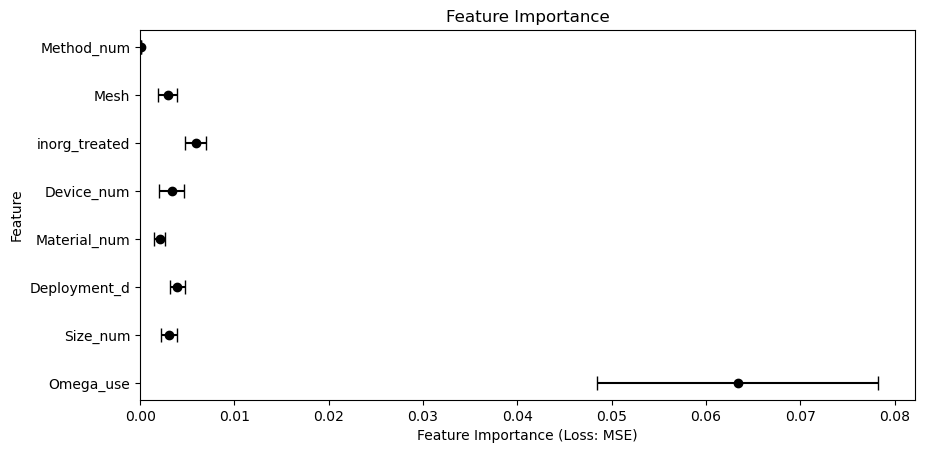

In [9]:
r = r_multi['neg_mean_squared_error']
y = pd.Series(range(0,len(feature_names))) + 0.5
fig = plt.figure(figsize=(10,0.6*len(feature_names)))
plt.errorbar(r.importances_mean, y, xerr=r.importances_std, ls="", marker="o", capsize=5, color='black')
plt.yticks(y, feature_names)
plt.title('Feature Importance')
plt.xlabel("Feature Importance (Loss: MSE)")
plt.ylabel("Feature")
plt.xlim(0)
plt.show()

## Partial Dependence Plots (PDPs) (Figure 9)

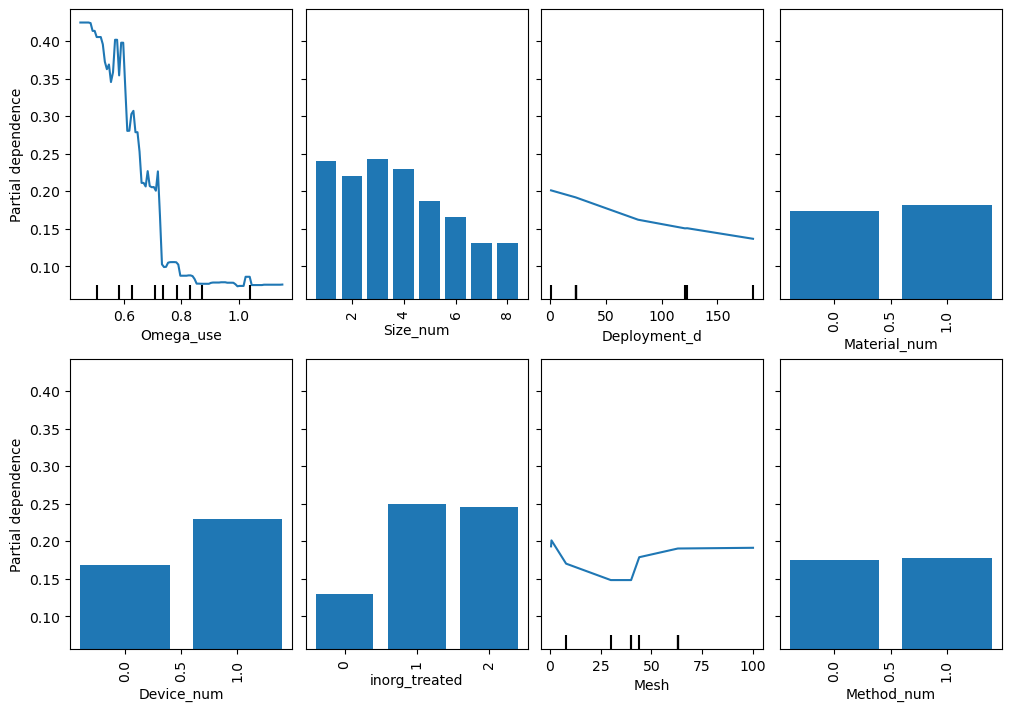

In [10]:
features_info = {
    # features of interest
    "features": ["Omega_use", "Size_num", "Deployment_d", 'Material_num',
          "Device_num", "inorg_treated", "Mesh", 'Method_num'],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": [1,3,4,5,7]
}

_, ax = plt.subplots(ncols=4, nrows=2, figsize=(10, 7), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    xgbr,
    X_train,
    **features_info,
    ax=ax,
)

